#### Data Loading

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm
from matplotlib.patches import Circle
import math

# Earth's radius in meters
EARTH_RADIUS_METERS = 6371000
# Load GPS Data and Convert to Spatial Coordinates
data_frame = pd.read_csv("data/fordulokor.csv", delimiter=';')
latitudes = data_frame['Lat'].values
longitudes = data_frame['Lon'].values


#### GPS to Spatial Coordinate

In [5]:
def gps_to_cartesian_coordinates(lat_values, lon_values):
    lat_radians = np.radians(lat_values)
    lon_radians = np.radians(lon_values)
    
    x_coords = EARTH_RADIUS_METERS * np.cos(lat_radians) * np.cos(lon_radians)
    y_coords = EARTH_RADIUS_METERS * np.cos(lat_radians) * np.sin(lon_radians)
    z_coords = EARTH_RADIUS_METERS * np.sin(lat_radians)
    
    return np.vstack((x_coords, y_coords, z_coords)).T

# Convert GPS lat/lon to 3D Cartesian coordinates
spatial_points = gps_to_cartesian_coordinates(latitudes, longitudes)
print(spatial_points[:5])

[[4070215.47059326 1406522.67004136 4695176.35468605]
 [4070215.46971152 1406522.66841131 4695176.35593873]
 [4070215.46971152 1406522.66841131 4695176.35593873]
 [4070215.46942928 1406522.67759131 4695176.35343337]
 [4070215.47201102 1406522.67848347 4695176.35092802]]


#### Project the 3D points onto the plane of the ground plane to obtain 2D coordinates using Local ENU Cartesian Coordinate System

The ENU coordinate system is a local 3D Cartesian coordinate system defined for a specific point on the Earth's surface. It consists of East (E), North (N), and Up (U) vectors, forming a coordinate frame tangent to the Earth's surface at the chosen location. 

<img src="data/Ecef_coordinates.png" alt="" width="600"/>
In this setup:

The Earth is represented in the ECEF (Earth-Centered, Earth-Fixed) coordinate system. Latitude (𝜙) and longitude (λ) define the position on the Earth's surface.


For a given position on Earth, defined by latitude (φ) and longitude (λ), the ENU coordinate system  is set up as follows:

#### East Vector (E):

The East vector points toward increasing longitude and is orthogonal to the Up vector:

E = [-sin(λ), cos(λ), 0]

where:

- λ (longitude) defines the direction eastward.
- sin(λ) and cos(λ) determine the orientation of the East vector in ECEF coordinates.

#### North Vector (N):

The North vector points toward increasing latitude and is orthogonal to both the East and Up vectors:

 N = [-sin(φ) * cos(λ), -sin(φ) * sin(λ), cos(φ)]

where:

- φ (latitude) defines the direction northward.
- The sin(φ), cos(φ), sin(λ), and cos(λ) terms adjust the northward component in ECEF coordinates.




#### Up Vector (U):

The Up vector points away from the Earth's surface, perpendicular to the ENU plane:
   U = [cos(φ) * cos(λ), cos(φ) * sin(λ), sin(φ)]

where:

 - φ and λ specify the location on Earth's surface.
- cos(φ) and sin(φ) adjust the direction outward, while cos(λ) and sin(λ) account for orientation.

#### Projecting 3D ECEF Points onto the 2D ENU Plane:

To project a 3D point in the ECEF coordinate system onto the 2D ENU plane:

1. Translate the Point to the Local ENU Origin:

- Choose a reference point P_ref in ECEF coordinates as the ENU origin.

- For a point P_ECEF, compute its position relative to the ENU origin:

    P_local = P_ECEF - P_ref

- This translation centers P_ECEF to the ENU origin, creating a local point, P_local.


 2. Project onto the East and North Axes:

- East (x) Coordinate:

#### Project P_local onto the East vector:

 x = P_local . E

= (P_local)_x * E_x + (P_local)_y * E_y + (P_local)_z * E_z

where (P_local)_x, (P_local)_y, and (P_local)_z are the components of P_local in ECEF, and E_x, E_y, E_z are the components of the East vector.

- North (y) Coordinate:

#### Project P_local onto the North vector:

y = P_local . N

 = (P_local)_x * N_x + (P_local)_y * N_y + (P_local)_z * N_z

 where N_x, N_y, and N_z are the components of the North vector.

The resulting (x, y) coordinates represent the position of the point in the 2D ENU plane, projecting the 3D ECEF point onto the local tangent plane at the reference point.

Reference: For more details, see the Local Tangent Plane Coordinates (https://en.m.wikipedia.org/wiki/Local_tangent_plane_coordinates).



In [6]:
# Set up the reference point and ENU vectors for projection to 2D
reference_latitude, reference_longitude = latitudes[0], longitudes[0]
reference_cartesian_point = gps_to_cartesian_coordinates(reference_latitude, reference_longitude)[0]

# Convert latitude and longitude to radians
latitude_rad = np.radians(reference_latitude)
longitude_rad = np.radians(reference_longitude)

# Calculate unit vectors for the tangent plane (East, North, Up)
east_unit_vector = np.array([-np.sin(longitude_rad), np.cos(longitude_rad), 0])
north_unit_vector = np.array([-np.sin(latitude_rad) * np.cos(longitude_rad),
                              -np.sin(latitude_rad) * np.sin(longitude_rad),
                              np.cos(latitude_rad)])
# Calculate the Up unit vector using the formula
up_unit_vector = np.array([np.cos(latitude_rad) * np.cos(longitude_rad),
                           np.cos(latitude_rad) * np.sin(longitude_rad),
                           np.sin(latitude_rad)])
def project_point_to_plane(point_3d, reference_point, east_vector, north_vector):
    vector_from_ref = point_3d - reference_point
    x_projection = np.dot(vector_from_ref, east_vector)
    y_projection = np.dot(vector_from_ref, north_vector)
    return np.array([x_projection, y_projection])

# Project each 3D point onto the tangent (2D East-North) plane
projected_points_2d = np.array([project_point_to_plane(point, reference_cartesian_point, east_unit_vector, north_unit_vector) for point in spatial_points])



<p style="color: white">Proximity-based merging or distance-based deduplication: Filtering by mergiing the 2D points which are close to each other.</p>

In [7]:

def is_close(point, existing_points, threshold):
    """
    Check if a point is close to any existing points within a given threshold.
    
    Parameters:
    - point: The current point to check.
    - existing_points: List of already merged points.
    - threshold: Distance below which two points are considered close.
    
    Returns:
    - True if the point is close to any existing point, False otherwise.
    """
    return any(np.linalg.norm(point - existing) < threshold for existing in existing_points)

def merge_close_points(points, threshold):
    """
    Merges 2D points that are close to each other by averaging their positions.
    
    Parameters:
    - points: A 2D numpy array of shape (n, 2).
    - threshold: Distance below which two points are merged.
    
    Returns:
    - A numpy array of merged points.
    """
    merged_points = []  # List to store merged points

    for point in points:
        # If no points are merged yet, or the current point is not close to any, add it
        if not merged_points or not is_close(point, merged_points, threshold):
            merged_points.append(point)
        else:
            # Find the index of the first existing point that is close to the current point
            idx = next(i for i, existing in enumerate(merged_points) 
                       if np.linalg.norm(point - existing) < threshold)
            # Merge by averaging the coordinates of the close points
            merged_points[idx] = (merged_points[idx] + point) / 2

    return np.array(merged_points)


merged_points_2D = merge_close_points(projected_points_2d, threshold=0.4)




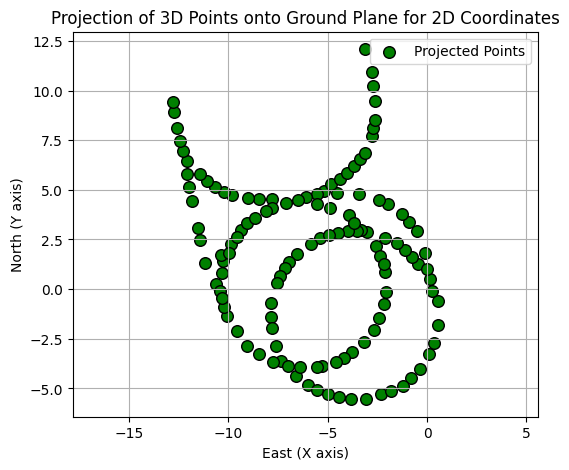

In [8]:
projected_points_2d=merged_points_2D
# Plot the merged 2D points

# Plot the projected 2D points
plt.figure(figsize=(6, 5))
plt.scatter(projected_points_2d[:, 0], projected_points_2d[:, 1], color='green', edgecolor='black', s=70, label='Projected Points')
plt.xlabel('East (X axis)')
plt.ylabel('North (Y axis)')
plt.title('Projection of 3D Points onto Ground Plane for 2D Coordinates')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.savefig("projected_3d_to_2d.png", dpi=300)
plt.show()


#### The implementation for RANSAC algorithm itself costs that for circle estimation .  
#### The radius is estimated from all the inliers.
##### Save the results in xyz format

Ransac Algorithm:
1. Set the desired confidence level and inlier distance threshold.
2. Loop until reaching the maximum required iterations. 
3. Randomly select the minimum number of points required to fit a circle (e.g., 3).
4. Use these points to estimate a circle's center and radius.
5. Count the data points within the distance threshold of this circle.
6. If the current model has the most inliers, update the best-fit circle and adaptively adjust the required iterations based on the inlier ratio.
7. If the algorithm has performed the calculated maximum number of iterations needed to reach the desired confidence level, it stops.
8. Return the circle with the most inliers and its inlier points.


Best Circle Center: [-3.57275438 -1.31581882]
Best Circle Radius: 4.234161309100636
Number of Inliers: 43
Refined Radius from all inliers: 4.227320089126974


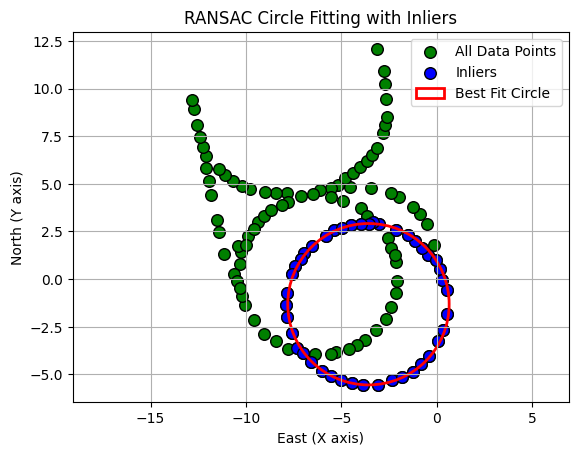

Results saved to circle_inliers.xyz


In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from numpy.linalg import norm

# Circle Fitting Using Least Squares
def fit_circle_least_squares(points_2d):
    """
    Fits a circle to a set of 2D points using least squares.

    Args:
        points_2d (np.ndarray): An array of 2D points with shape (n, 2).

    Returns:
        tuple: The center (cx, cy) and radius of the fitted circle.
    """
    # Set up the linear system of equations for circle parameters
    A = np.column_stack((np.ones(points_2d.shape[0]), -2 * points_2d[:, 0], -2 * points_2d[:, 1]))
    B = -(points_2d[:, 0]**2 + points_2d[:, 1]**2)
    
    # Solve for circle parameters using least squares
    param, _, _, _ = np.linalg.lstsq(A, B, rcond=None)
    constant, cx, cy = param
    
    # Calculate the circle's center and radius
    circle_center = np.array([cx, cy])
    circle_radius = np.sqrt(cx**2 + cy**2 - constant)
    
    return circle_center, circle_radius


def compute_inliers(data_points, center, radius, threshold):
    """
    Computes inliers for a given circle model based on a distance threshold.

    Args:
        data_points (np.ndarray): Array of 2D points.
        center (np.ndarray): Center of the circle.
        radius (float): Radius of the circle.
        threshold (float): Distance threshold to define inliers.

    Returns:
        np.ndarray: Array of inliers.
    """
    inliers = []
    # Iterate over each point to check if it is within the inlier threshold
    for point in data_points:
        # Calculate the Euclidean distance from the point to the circle center
        distance_to_center = np.linalg.norm(point - center)
        # Check if the point is within the threshold distance from the circle
        if abs(distance_to_center - radius) < threshold:
            inliers.append(point)
    return np.array(inliers)



def ransac_circle_fit(data_points, sample_size=3, threshold=0.2, confidence=0.95):
    """
    Runs the RANSAC algorithm to fit a circle to data points with outliers.

    Args:
        data_points (np.ndarray): Array of 2D points.
        sample_size (int): Number of points needed to fit the model.
        threshold (float): Distance threshold for identifying inliers.
        confidence (float): Desired confidence level for the best model.

    Returns:
        tuple: Best-fit circle (center, radius) and the inliers.
    """
    # Initialize variables for best circle and inliers
    best_circle = None
    best_inliers = []
    max_inliers_count = 0
    num_points = len(data_points)
    max_iterations = math.inf  # Set initial max_iterations to infinity for adaptive control
    iteration = 0

    # Loop until the required number of iterations is reached
    while iteration < max_iterations:
        # Randomly select a subset of points to form a candidate circle
        sample_points = data_points[np.random.choice(num_points, sample_size, replace=False), :]

        # Fit a circle to the selected points
        center, radius = fit_circle_least_squares(sample_points)

        # Compute inliers for the fitted circle
        inliers = compute_inliers(data_points, center, radius, threshold)

        # Update best model if the current model has more inliers than previous models
        if len(inliers) > max_inliers_count:
            max_inliers_count = len(inliers)
            best_circle = (center, radius)
            best_inliers = inliers

            # Update the required number of iterations adaptively
            outlier_ratio = 1 - max_inliers_count / num_points
            max_iterations = math.log(1 - confidence) / math.log(1 - (1 - outlier_ratio) ** sample_size)

        # Increment iteration count
        iteration += 1

    return best_circle, best_inliers


# Plot Circle Fitting Results
def plot_circle_fitting_results(all_points, circle_center, circle_radius, inliers):
    """
    Plots the fitted circle and the inlier points.

    Args:
        all_points (np.ndarray): Array of all 2D data points.
        circle_center (np.ndarray): Center of the fitted circle.
        circle_radius (float): Radius of the fitted circle.
        inliers (np.ndarray): Array of inlier points.
    """
    fig, ax = plt.subplots()
    ax.scatter(all_points[:, 0], all_points[:, 1], color='green', edgecolor='black', s=70, label='All Data Points')
    ax.scatter(inliers[:, 0], inliers[:, 1], color='blue', edgecolor='black', s=70, label='Inliers')
    
    # Draw Circle for the best-fit model
    circle_patch = Circle(circle_center, circle_radius, color='red', fill=False, linewidth=2, label='Best Fit Circle')
    ax.add_patch(circle_patch)

    ax.set_xlabel('East (X axis)')
    ax.set_ylabel('North (Y axis)')
    ax.set_title('RANSAC Circle Fitting with Inliers')
    ax.legend()
    ax.axis('equal')
    ax.grid(True)
    plt.savefig("ransac_circle_fitting.png", dpi=300)
    plt.show()


# Save Circle and Inliers to XYZ File
def save_circle_and_inliers_to_xyz(file_name, inlier_points):
    """
    Saves the circle center, radius, and inliers to a .xyz file.

    Args:
        file_name (str): The name of the file to save.
        center_coords (np.ndarray): Center coordinates of the circle.
        radius (float): Radius of the circle.
        inlier_points (np.ndarray): Array of inlier points.
    """
    with open(file_name, "w") as file:
        
        # Write each inlier point with z=0 for 2D
        for point in inlier_points:
            file.write(f"{point[0]} {point[1]} 0.0\n")
    print(f"Results saved to {file_name}")


best_fit_circle, circle_inliers = ransac_circle_fit(projected_points_2d, sample_size=3, threshold=0.2)

# Check if a valid circle was found and print results
if best_fit_circle:
    circle_center, best_radius = best_fit_circle
    print("Best Circle Center:", circle_center)
    print("Best Circle Radius:", best_radius)
    print("Number of Inliers:", len(circle_inliers))


    # Refine radius estimate from inliers
    refined_radius = np.mean([np.linalg.norm(point - circle_center) for point in circle_inliers])
    print(f"Refined Radius from all inliers: {refined_radius}")

    # Plot results
    plot_circle_fitting_results(projected_points_2d, circle_center, best_radius, circle_inliers )

    # Save results to file
    save_circle_and_inliers_to_xyz("circle_inliers.xyz",  circle_inliers)
else:
    print("No valid circle found.")
